<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%A0%D0%B0%D0%B7%D0%BC%D0%B5%D1%80_%D0%B2%D0%B0%D0%BB%D0%B8%D0%B4%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперимент: "Размер валидации"

Проект: "Оптимизация инвестиционных портфелей методами машинного обучения"

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург

10.01.2021

[VK](https://vk.com/alekseyenin)
[OK](http://ok.ru/profile/404477133)
[Twitter](https://twitter.com/EninAleksey)
[FB](https://www.facebook.com/alex.prog.1)
[Telegramm](https://t.me/AleseyEnin)
[Habr](https://habr.com/ru/users/eavprog/posts/)
[VC](https://vc.ru/u/262921-aleksey-enin)
[GitHub](https://github.com/prog815)

# Загрузка библиотек

In [ ]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-e10ugrmh
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-e10ugrmh
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=653adb637aa445d43b7424eac57e6c973299b8e27422cbd08ed0f1addad3414e
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5hhcqn3/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-mr186a81
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-mr186a81
  Created wheel for progOrder: filename=progOrder-0.0.5-cp36-none-any.whl size=2485 sha256=739f051e69ffb4af70b3366b6f4bcf9af39ed8238536b3cd2eaa8704f1b7f1b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhr4pgb0/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [ ]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData, kach, bs2y, y2bs
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Загрузка данных

In [ ]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2003, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2003-01-04,6120.00,6155.00,6100.00,6130.00,2358
2003-01-05,6111.01,6145.00,6102.70,6145.00,956
2003-01-08,6145.00,6190.00,5960.00,6135.05,8771
2003-01-09,6120.01,6250.00,6120.00,6225.00,10579
2003-01-10,6240.00,6285.00,6225.10,6261.00,8882
...,...,...,...,...,...
2021-01-08,275.11,283.99,275.11,283.64,88672940
2021-01-11,282.75,292.95,279.48,289.49,112210400
2021-01-12,290.50,296.07,286.70,289.99,78890100


In [ ]:
ohlcv = data.values[:,:5]
d_ohlcv = np.array(ohlcv)
for n in range(1,len(ohlcv)):
    b = ohlcv[n-1,3]
    d_ohlcv[n,:] = (ohlcv[n,:] - b) / b
d_ohlcv[0,:] = np.nan

data['dOpen'] = d_ohlcv[:,0]
data['dHigh'] = d_ohlcv[:,1]
data['dLow'] = d_ohlcv[:,2]
data['dClose'] = d_ohlcv[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2003-01-04,6120.00,6155.00,6100.00,6130.00,2358,NaN,NaN,NaN,NaN
2003-01-05,6111.01,6145.00,6102.70,6145.00,956,-0.003098,0.002447,-0.004454,0.002447
2003-01-08,6145.00,6190.00,5960.00,6135.05,8771,0.000000,0.007323,-0.030106,-0.001619
2003-01-09,6120.01,6250.00,6120.00,6225.00,10579,-0.002451,0.018737,-0.002453,0.014662
2003-01-10,6240.00,6285.00,6225.10,6261.00,8882,0.002410,0.009639,0.000016,0.005783
...,...,...,...,...,...,...,...,...,...
2021-01-08,275.11,283.99,275.11,283.64,88672940,0.007987,0.040523,0.007987,0.039241
2021-01-11,282.75,292.95,279.48,289.49,112210400,-0.003138,0.032823,-0.014666,0.020625
2021-01-12,290.50,296.07,286.70,289.99,78890100,0.003489,0.022730,-0.009638,0.001727


# Поиск гиперпараметров

## Целевая функция

In [ ]:
# %%time

orderLifeLen = 50                           # срок жизни ордера

# (+) !!! - определить выборки

allLen = data.shape[0]                      # размер всей выборки
allIdx = np.arange(allLen,dtype=np.int16)
testPart = 0.1                              # доля тестовой
testLen = int(np.round(allLen*testPart))    # длина тестовой выборки
trainLen = allLen - testLen                 # длина трейновой выборки (обучающая + валидационная)
# valLen = orderLifeLen                       # длина валидационной выборки

# --------------------------------------------------

def get_X(lookback):
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(lookback)])
    X = np.hstack((X,np.vstack((data.index.month,data.index.day,data.index.dayofweek)).T))
    return X

# --------------------------------------------------

def getQualityMethod(lookback,     # окно задержки
                     learnLen,     # глубина обучения
                     valLen,       # глубина валидации
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
    
    # (+) !!! - случайная точка расчета
    randomPoint = np.random.randint(1+learnLen+lookback+orderLifeLen,trainLen-valLen)

    # подготовка сигналов
    b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = get_X(lookback)
    y = b*2+s

    # разделение выборок
    X_learn = X[(randomPoint-learnLen-orderLifeLen):(randomPoint-orderLifeLen)]
    y_learn = y[(randomPoint-learnLen-orderLifeLen):(randomPoint-orderLifeLen)]
    X_valid = X[randomPoint:(randomPoint+valLen)]
    y_valid = y[randomPoint:(randomPoint+valLen)]

    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)
    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    res = kach(num2bs(pred_valid),num2bs(y_valid),dTP,dSL)

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -0.1

    return res

res = getQualityMethod(30,1000,60,7,200,0.004,0.01)
print(res)

-0.0020666666666666667


## Создание модели

### Создание

In [ ]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      learnLen = range(100,2000),
                      valLen = range(2,200),
                      max_depth = range(2,100),
                      n_estimators = range(10,500),
                      dTP = np.round(np.arange(0.0001,0.1,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.1,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [ ]:
fn = '/content/drive/My Drive/prog/model_rv_10.01.2021.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)


## Бесконечный цикл обучения

In [ ]:
while True:
    modelGA.fit(50,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

1132 {'quality': -0.013993076923076922, 'lookback': 102, 'learnLen': 1750, 'valLen': 130, 'max_depth': 81, 'n_estimators': 135, 'dTP': 0.0452, 'dSL': 0.049}
finish -  1162 {'quality': -0.0036880952380952364, 'lookback': 99, 'learnLen': 327, 'valLen': 168, 'max_depth': 80, 'n_estimators': 129, 'dTP': 0.0524, 'dSL': 0.0344}
1189 {'quality': 0.0004673228346456694, 'lookback': 103, 'learnLen': 401, 'valLen': 127, 'max_depth': 41, 'n_estimators': 66, 'dTP': 0.0477, 'dSL': 0.0289}
finish -  1212 {'quality': 0.003423428571428571, 'lookback': 92, 'learnLen': 539, 'valLen': 175, 'max_depth': 88, 'n_estimators': 133, 'dTP': 0.076, 'dSL': 0.0298}
1237 {'quality': -0.1, 'lookback': 102, 'learnLen': 460, 'valLen': 114, 'max_depth': 95, 'n_estimators': 136, 'dTP': 0.0624, 'dSL': 0.0311}
1262 {'quality': -0.0018184523809523809, 'lookback': 102, 'learnLen': 1314, 'valLen': 168, 'max_depth': 89, 'n_estimators': 72, 'dTP': 0.0501, 'dSL': 0.0254}
finish -  1262 {'quality': -0.0018184523809523809, 'lookba

## Графики оптимизации параметров в генетике

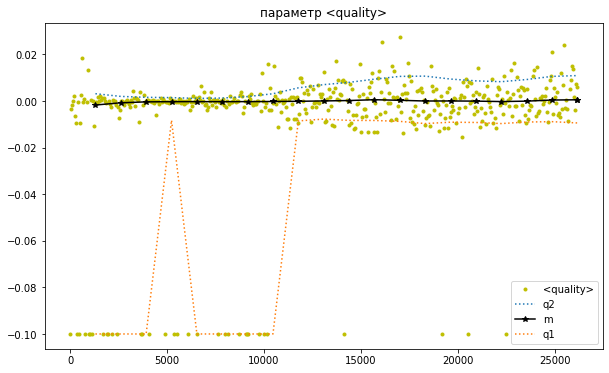

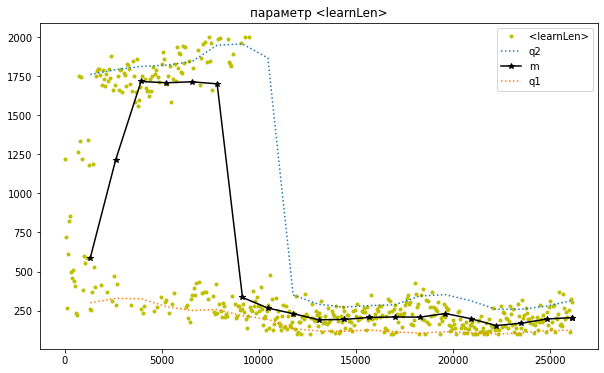

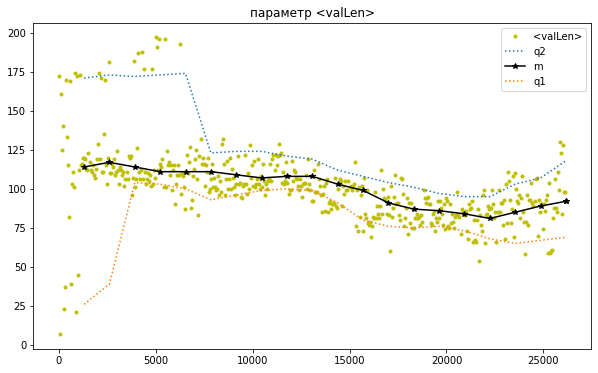

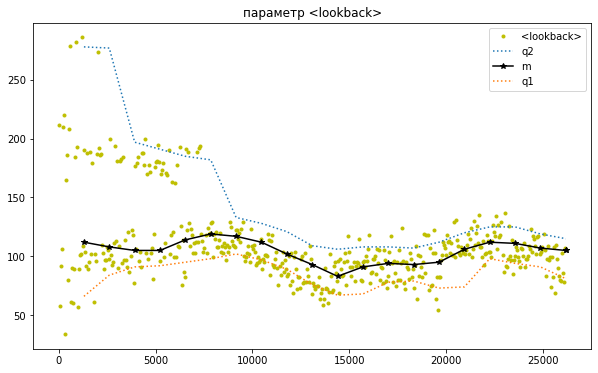

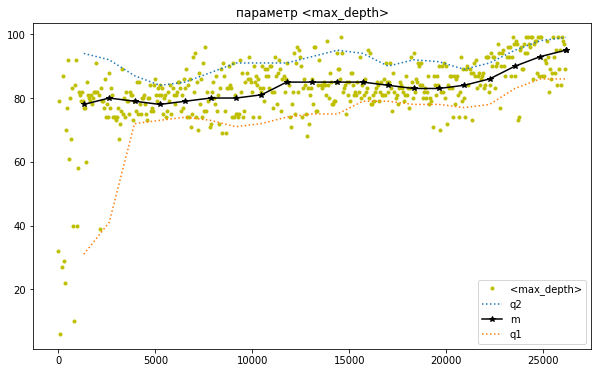

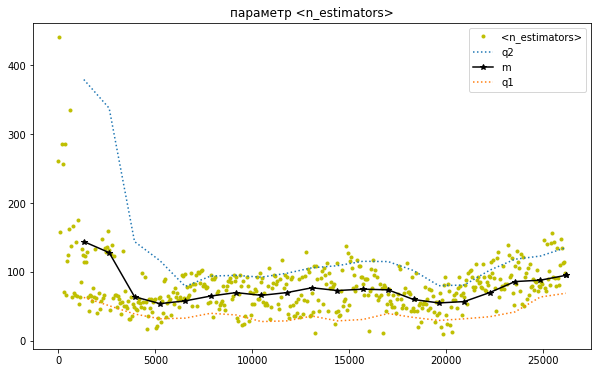

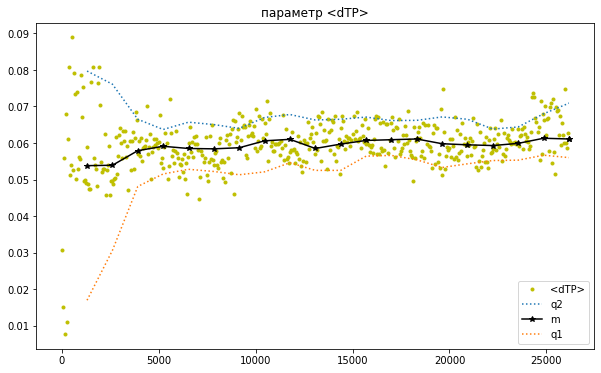

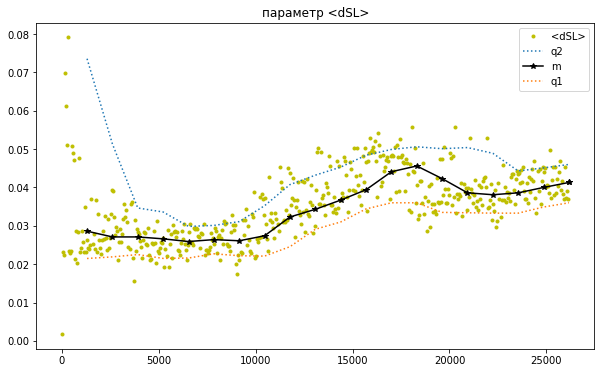

In [ ]:
modelGA.plot_hist_new(('quality','learnLen','valLen','lookback','max_depth','n_estimators','dTP','dSL'))

## Положительные

In [ ]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


Выходные данные были обрезаны до нескольких последних строк (5000).
16277 {'quality': 0.013679374999999999, 'lookback': 97, 'learnLen': 252, 'valLen': 80, 'max_depth': 78, 'n_estimators': 66, 'dTP': 0.0629, 'dSL': 0.0458}
16278 {'quality': 0.01192142857142857, 'lookback': 103, 'learnLen': 270, 'valLen': 98, 'max_depth': 90, 'n_estimators': 84, 'dTP': 0.0572, 'dSL': 0.0362}
16279 {'quality': 0.0001322429906542058, 'lookback': 117, 'learnLen': 267, 'valLen': 107, 'max_depth': 83, 'n_estimators': 95, 'dTP': 0.0613, 'dSL': 0.0513}
16281 {'quality': 0.02058589743589743, 'lookback': 100, 'learnLen': 147, 'valLen': 78, 'max_depth': 85, 'n_estimators': 93, 'dTP': 0.0647, 'dSL': 0.05}
16283 {'quality': 0.002976249999999999, 'lookback': 84, 'learnLen': 143, 'valLen': 80, 'max_depth': 87, 'n_estimators': 102, 'dTP': 0.0636, 'dSL': 0.0427}
16286 {'quality': 0.0005206896551724139, 'lookback': 85, 'learnLen': 255, 'valLen': 87, 'max_depth': 81, 'n_estimators': 51, 'dTP': 0.0617, 'dSL': 0.046}
16293 

## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0414,
 'dTP': 0.06,
 'learnLen': 249,
 'lookback': 92,
 'max_depth': 93,
 'n_estimators': 108,
 'valLen': 104}

# Тестирование лучшей

## входы и выходы обучения

In [ ]:
# подготовка сигналов
b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=best_par['dSL'],dTP=best_par['dTP'])

# подготовка входов
X = get_X(best_par['lookback'])
y = b*2+s

## цикл расчета

In [ ]:
b_ = b * np.nan
s_ = s * np.nan

dLen = min(100,best_par['valLen'])

# цикл по точкам расчета
for calcPoint in range(best_par['learnLen']+best_par['lookback']+orderLifeLen,allLen-best_par['valLen'],dLen):
    
    # обучающая выборка
    X_learn = X[(calcPoint-best_par['learnLen']-orderLifeLen):(calcPoint-orderLifeLen)]
    y_learn = y[(calcPoint-best_par['learnLen']-orderLifeLen):(calcPoint-orderLifeLen)]
    X_test = X[calcPoint:(calcPoint+dLen)]
    
    # создание модели
    model_test = RandomForestClassifier(max_depth=best_par['max_depth'],class_weight='balanced',n_estimators=best_par['n_estimators'])

    # обучение модели
    model_test.fit(X_learn, y_learn)

    # прогноз модели
    pred_test = model_test.predict(X_test)
    b_test,s_test = y2bs(pred_test)

    # запись результатов
    b_[calcPoint:(calcPoint+dLen)] = b_test
    s_[calcPoint:(calcPoint+dLen)] = s_test

    print(calcPoint,allLen)



391 4495
491 4495
591 4495
691 4495
791 4495
891 4495
991 4495
1091 4495
1191 4495
1291 4495
1391 4495
1491 4495
1591 4495
1691 4495
1791 4495
1891 4495
1991 4495
2091 4495
2191 4495
2291 4495
2391 4495
2491 4495
2591 4495
2691 4495
2791 4495
2891 4495
2991 4495
3091 4495
3191 4495
3291 4495
3391 4495
3491 4495
3591 4495
3691 4495
3791 4495
3891 4495
3991 4495
4091 4495
4191 4495
4291 4495


## Таблица результатов

In [ ]:
df_=pd.DataFrame(index=data.index)
df_['BUY'] = b_
df_['BUY_open'] = data['<CLOSE>']
df_['BUY_tp'] = np.round(data['<CLOSE>']*(1+best_par['dTP']),2)
df_['BUY_sl'] = np.round(data['<CLOSE>']*(1-best_par['dSL']),2)
df_['SELL'] = s_
df_['SELL_open'] = data['<CLOSE>']
df_['SELL_tp'] = np.round(data['<CLOSE>']*(1-best_par['dTP']),2)
df_['SELL_sl'] = np.round(data['<CLOSE>']*(1+best_par['dSL']),2)
df_

,BUY,BUY_open,BUY_tp,BUY_sl,SELL,SELL_open,SELL_tp,SELL_sl
<DATE>,,,,,,,,
2003-01-04,NaN,6130.00,6497.80,5876.22,NaN,6130.00,5762.20,6383.78
2003-01-05,NaN,6145.00,6513.70,5890.60,NaN,6145.00,5776.30,6399.40
2003-01-08,NaN,6135.05,6503.15,5881.06,NaN,6135.05,5766.95,6389.04
2003-01-09,NaN,6225.00,6598.50,5967.28,NaN,6225.00,5851.50,6482.72
2003-01-10,NaN,6261.00,6636.66,6001.79,NaN,6261.00,5885.34,6520.21
...,...,...,...,...,...,...,...,...
2021-01-08,NaN,283.64,300.66,271.90,NaN,283.64,266.62,295.38
2021-01-11,NaN,289.49,306.86,277.51,NaN,289.49,272.12,301.47
2021-01-12,NaN,289.99,307.39,277.98,NaN,289.99,272.59,302.00


## Сигналы

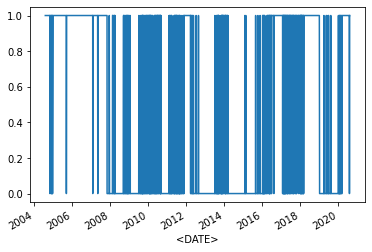

In [ ]:
df_['BUY'].plot()

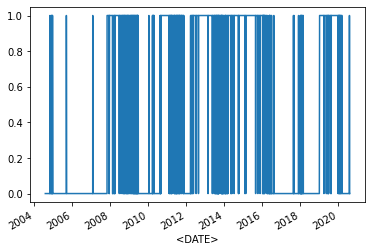

In [ ]:
df_['SELL'].plot()

## Качество на тесте

In [ ]:
bs_y = np.vstack((b,s)).T
bs_y_ = np.vstack((b_,s_)).T
idx = ~np.any(np.isnan(bs_y + bs_y_),axis=1)

trainIdx = np.copy(idx)
trainIdx[trainLen:] = False
kachTrain = kach(bs_y_[trainIdx],bs_y[trainIdx],best_par['dTP'],best_par['dSL'])
print('kachTrain',kachTrain,'%/year',((kachTrain+1)**252-1)*100)

testIdx = np.copy(idx)
testIdx[:trainLen] = False
kachTest = kach(bs_y_[testIdx],bs_y[testIdx],best_par['dTP'],best_par['dSL'])
print('kachTest',kachTest,'%/year',((kachTest+1)**252-1)*100)

kachTrain 0.0014847290640394094 %/year 45.33543677226888
kachTest -0.00478179190751445 %/year -70.11763967693592


In [ ]:
b_.shape

(4495,)

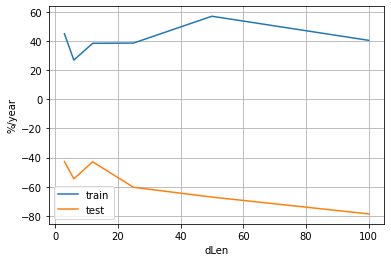

In [ ]:
testRes = np.array([[100,40.41807363155978,-78.6058822416952],
                    [50,56.952950703460004,-67.05143186758438],
                    [25,38.5447921396503,-60.34072389948084],
                    [12,38.4045886882473,-42.86306575659433],
                    [6,26.86890743375503,-54.55798363135703],
                    [3,44.94563568171357,-42.656392093449]])
plt.plot(testRes[:,0],testRes[:,1:])
plt.legend(['train','test'])
plt.ylabel('%/year')
plt.xlabel('dLen')
plt.grid()
plt.show()
